In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

# Generate Data

In [4]:
using Random: shuffle!, AbstractRNG, Xoshiro

In [5]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [6]:
n_hd = 512
n_batch = 128

128

In [7]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [8]:
function choose_symbols(n_samples::Int, n_symbols::Int, d_vsa::Int, rng::AbstractRNG)
    codebook = random_symbols((d_vsa, n_symbols), rng)
    selection = rand(rng, 1:n_symbols, n_samples)
    return selection, codebook
end

choose_symbols (generic function with 1 method)

In [9]:
a, b = choose_symbols(20, n_batch, n_hd, rng)

([93, 48, 4, 11, 85, 63, 92, 22, 68, 60, 110, 23, 38, 128, 46, 94, 97, 80, 36, 41], [-0.0910341739654541 -0.824973464012146 … -0.06740546226501465 0.8688455820083618; -0.652850866317749 -0.8821024894714355 … 0.7837827205657959 -0.3686896562576294; … ; -0.1820603609085083 -0.3686501979827881 … 0.7178592681884766 -0.8282173871994019; -0.8696286678314209 -0.9998259544372559 … -0.931610107421875 -0.7670974731445312])

In [10]:
a |> size

(20,)

In [11]:
b |> size

(512, 128)

In [12]:
function select_edges(n_samples::Int, n_links::Tuple{<:Int, <:Int}, rng::AbstractRNG)
    ids = collect(1:n_samples)
    links_per_sample = rand(rng, n_links, n_samples)
    edges = [ids[rand(rng, 1:n_samples, n)] for n in links_per_sample]
    return edges
end

select_edges (generic function with 1 method)

In [13]:
select_edges(20, (1,3), rng)

20-element Vector{Vector{Int64}}:
 [15]
 [16]
 [2]
 [14]
 [3]
 [13, 19, 9]
 [20]
 [19, 15, 9]
 [16, 12, 8]
 [2, 15, 12]
 [6, 11, 17]
 [10]
 [3, 9, 1]
 [16, 19, 6]
 [6]
 [18]
 [7, 13, 13]
 [10]
 [4]
 [16, 5, 1]

In [14]:
function generate_addresses(n_samples::Int,  n_vsa::Int, rng::AbstractRNG)
    header = random_symbols((n_vsa, 1), rng)
    powers = collect(0:n_samples-1)
    addresses = [v_bind(header, header .* p)[:,1] for p in powers]
    addresses = stack(addresses, dims=2)
    return header, addresses
end

generate_addresses (generic function with 1 method)

In [15]:
h, ad = generate_addresses(20, n_hd, rng)

([-0.377943754196167; -0.9322184324264526; … ; 0.039890289306640625; -0.1195073127746582;;], [-0.377943754196167 -0.755887508392334 … 0.8190686702728271 0.44112491607666016; -0.9322184324264526 0.13556313514709473 … 0.2878497838973999 -0.6443686485290527; … ; 0.039890289306640625 0.07978057861328125 … 0.7579154968261719 0.7978057861328125; -0.1195073127746582 -0.2390146255493164 … -0.27063894271850586 -0.39014625549316406])

In [16]:
skv = [similarity(h, v_bind(h, p .* h))[1] for p in 0.0:0.01:5.0];

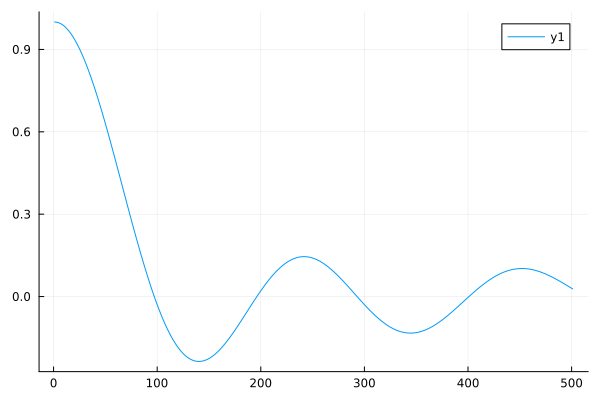

In [17]:
plot(skv)

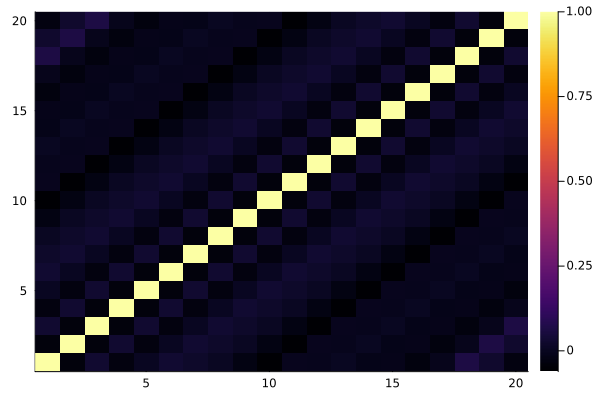

In [18]:
heatmap(similarity_outer(ad[:,:,1:1], ad[:,:,1:1], dims=2)[:,:,1])

In [19]:
struct KeyValueData
    color_marker::AbstractArray{<:Real,2}
    colors::AbstractArray{<:Real,2}
    color_bank::AbstractArray{<:Real,2}
    color_choices::AbstractArray{<:Int,1}

    shape_marker::AbstractArray{<:Real,2}
    shapes::AbstractArray{<:Real,2}
    shape_bank::AbstractArray{<:Real,2}
    shape_choices::AbstractArray{<:Int,1}

    location_marker::AbstractArray{<:Real,2}
    locations::AbstractArray{<:Real,2}
    location_index::AbstractArray{<:Int,1}

    link_marker::AbstractArray{<:Real,2}
    links::AbstractVector{AbstractArray{<:Real,2}}
    link_choices::AbstractVector{AbstractVector{<:Int}}

    symbols::AbstractArray{<:Real,2}
end

In [20]:
function KeyValueData(n_samples::Int; n_colors::Int = 100, n_shapes::Int = 20, n_links::Tuple{<:Int, <:Int} = (1,3), d_vsa::Int = 512, rng::AbstractRNG)
    generate_marker = () -> random_symbols((d_vsa, 1), rng)

    #colors
    color_marker = generate_marker()
    color_choices, color_bank = choose_symbols(n_samples, n_colors, d_vsa, rng)
    colors = color_bank[:,color_choices]

    #shapes
    shape_marker = generate_marker()
    shape_choices, shape_bank = choose_symbols(n_samples, n_shapes, d_vsa, rng)
    shapes = shape_bank[:,shape_choices]

    #locations
    location_marker = generate_marker()
    _, locations = generate_addresses(n_samples, d_vsa, rng)
    locations_indices = collect(1:n_samples)

    #links
    link_marker = generate_marker()
    link_indices = select_edges(n_samples, n_links, rng)
    links = [locations[:,idx] for idx in link_indices]

    #combine data
    symbols = zeros(Float64, (d_vsa, n_samples))
    for i in 1:n_samples
        color_string = v_bind(color_marker, colors[:, i:i])
        shape_string = v_bind(shape_marker, shapes[:, i:i])
        location_string = v_bind(location_marker, locations[:, i:i])

        link_strings = stack([locations[:, l] for l in link_indices[i]], dims=2)
        link_string = v_bind(link_marker, v_bundle(link_strings, dims=2))

        string = v_bundle(stack([color_string, shape_string, location_string, link_string], dims=2), dims=2)
        symbols[:,i:i] = string
    end

    return KeyValueData(color_marker,
                         colors,
                         color_bank,
                         color_choices,
                         shape_marker,
                         shapes,
                         shape_bank,
                         shape_choices,
                         location_marker,
                         locations,
                         locations_indices,
                         link_marker,
                         links,
                         link_indices,
                         symbols)

    # return KeyValueData(color_marker,
    #                      colors,
    #                      color_choices,
    #                      shape_marker,
    #                      shapes,
    #                      shape_choices,
    #                      location_marker,
    #                      locations,
    #                      locations_indices,
    #                      link_marker,
    #                      links,
    #                      link_indices,
    #                      symbols)
    
end

KeyValueData

In [21]:
kv = KeyValueData(32, rng=rng)

KeyValueData([-0.8661201000213623; 0.19297277927398682; … ; -0.35880279541015625; 0.7882692813873291;;], [0.42590582370758057 0.605155348777771 … -0.4683654308319092 0.06126141548156738; -0.6399070024490356 -0.6593366861343384 … 0.03552377223968506 -0.7425521612167358; … ; 0.38557326793670654 0.9808140993118286 … -0.6360534429550171 0.12502527236938477; 0.19276118278503418 -0.11798632144927979 … 0.09099936485290527 0.17120003700256348], [0.22108304500579834 -0.9266397953033447 … 0.6492582559585571 -0.5852980613708496; -0.05466794967651367 0.6392378807067871 … -0.05855977535247803 0.05404102802276611; … ; 0.059370994567871094 -0.861544132232666 … -0.3269519805908203 -0.6070995330810547; -0.377269983291626 0.1941589117050171 … 0.5405981540679932 -0.5506776571273804], [75, 78, 4, 40, 86, 92, 57, 39, 42, 24  …  84, 21, 43, 78, 3, 42, 57, 79, 7, 56], [-0.29223179817199707; -0.21629250049591064; … ; 0.8317346572875977; -0.8419104814529419;;], [0.04459583759307861 0.0830085277557373 … -0.8419

In [22]:
kv.color_marker

512×1 Matrix{Float64}:
 -0.8661201000213623
  0.19297277927398682
  0.1739567518234253
 -0.22611427307128906
 -0.20363712310791016
  0.8024662733078003
 -0.3374354839324951
 -0.4978381395339966
  0.04387235641479492
  0.9656368494033813
 -0.7153493165969849
 -0.32590556144714355
  0.16817843914031982
  ⋮
 -0.1240311861038208
  0.29347705841064453
  0.8144911527633667
  0.16163313388824463
  0.7998852729797363
  0.8840855360031128
  0.4260793924331665
  0.4552873373031616
  0.3120929002761841
  0.9918069839477539
 -0.35880279541015625
  0.7882692813873291

In [23]:
import Base.length, Base.size

function length(kv::KeyValueData)
    return size(kv.locations,2)
end

function size(kv::KeyValueData)
    return kv.locations |> size
end

size (generic function with 441 methods)

In [24]:
length(kv)

32

In [25]:
kv_fields = [:color, :shape, :link, :location]

4-element Vector{Symbol}:
 :color
 :shape
 :link
 :location

In [26]:
"""
Given a field marker, an index, and a set of key values, construct a query
which represents a request to get a specific piece of information from the KV
set at index and return the desired answer corresponding to that query.
"""
function generate_direct_query(marker::Symbol, index::Int, kvs::KeyValueData)
    @assert index in 1:length(kvs) "Select an index within length(kvs) to query"
    @assert marker in kv_fields "Must choose valid subfield to query"    

    address = v_bind(kvs.location_marker, kvs.locations[:, index:index])

    #generate the query
    if marker == :color
        tag = kvs.color_marker
        value = kvs.colors[:, index:index]
    elseif marker == :shape
        tag = kvs.shape_marker
        value = kvs.shapes[:, index:index]
    elseif marker == :link
        tag = kvs.link_marker
        value = v_bundle(kvs.links[index], dims=2)
    else marker == :location
        tag = kvs.location_marker
        value = kvs.locations[:, index:index]
    end

    query = v_bundle((address, tag), dims=2)
    return query, value
end

generate_direct_query

In [27]:
dqx, dqy = generate_direct_query(:link, 10, kv)

([0.5197351574897767; 0.23234045505523682; … ; -0.10287302732467651; -0.6423741579055786;;], [-0.6718346450928974; 0.9461848903321581; … ; 0.2391245850540429; 0.6869968130105969;;])

In [28]:
"""
Given a field marker, an index, and a set of key values, construct a query
which represents a request to get a specific piece of information from the KV
set's neighbors at index and return the desired answer corresponding to that query.
"""
function generate_indirect_query(marker::Symbol, index::Int, kvs::KeyValueData)
    @assert index in 1:length(kvs) "Select an index within length(kvs) to query"
    @assert marker in kv_fields "Must choose valid subfield to query"    

    address = kvs.locations[:, index:index]
    link = kvs.link_marker
    link_indices = kvs.link_choices[index]

    #bundle together the result of the query from the child nodes
    function bundle_values(register, indices)
        values = register[:, indices]
        value = v_bundle(values, dims=2)
        return value
    end

    if marker == :color
        tag = kvs.color_marker
        value = bundle_values(kvs.colors, link_indices)
    elseif marker == :shape
        tag = kvs.shape_marker
        value = bundle_values(kvs.shapes, link_indices)
    elseif marker == :link
        tag = kvs.link_marker
        values = cat((kvs.links[link_indices]...), dims=2)
        #return values
        value = v_bundle(values, dims=2)
    else marker == :location
        tag = kvs.location_marker
        value = bundle_values(kvs.locations, link_indices)
    end

    reference = v_bundle((v_bind((kvs.location_marker, address), dims=2), kvs.link_marker), dims=2)
    query = v_bundle((v_bind((kvs.location_marker, reference), dims=2), tag), dims=2)
    return query, value
end

generate_indirect_query

In [29]:
iqx, iqy = generate_indirect_query(:link, 10, kv)

([-0.07767620682716364; -0.4698137640953064; … ; -0.04046264290809634; 0.9726848920066026;;], [-0.4764642763609094; -0.9596567518468291; … ; 0.9168999888738294; 0.43277054475624055;;])

In [30]:
"""
Given a desired number of samples and a key-value set, return a random
ordering of the possible queries from that set of key-values.
"""
function permute_shuffle(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    n_permutations = length(kv_fields) * length(kvs)
    @assert n_samples < n_permutations "Must have n_samples < n_permutations for unique samples"

    #select which queries to make at random
    permutations = [(field, i) for field in kv_fields, i in 1:length(kvs)]
    permutations = shuffle!(rng, permutations)[1:n_samples]
    return permutations
end

permute_shuffle

In [31]:
function direct_dataset(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    permutations = permute_shuffle(n_samples, kvs, rng)
    samples = map(x -> generate_direct_query(x[1],x[2],kvs), permutations)
    queries = stack([s[1][:] for s in samples])
    values = stack([s[2][:] for s in samples])
    return queries, values
end

direct_dataset (generic function with 1 method)

In [32]:
ddx, ddy = direct_dataset(100, kv, rng)

([0.1350426077842712 -0.4089899659156799 … -0.8948131203651428 -0.637587698288646; -0.3315642476081848 -0.19960182905197144 … -0.05426138639450074 0.9259910901267198; … ; -0.7085770090300706 -0.7493844946105149 … -0.858306976147379 0.47141844034194946; -0.4990971088409424 0.5414943099021912 … -0.9095087369162705 -0.01165604591369623], [0.8276315927505493 -0.9062849283218384 … -0.5711255073547363 0.8005715608596802; -0.8612439632415771 -0.7055126428604126 … 0.37463152408599854 0.2369626760482788; … ; -0.41813111305236816 0.9703257083892822 … 0.47690749168395996 0.3218430280685425; -0.21200931072235107 0.2454131841659546 … 0.5128493309020996 0.8677661418914795])

In [33]:
ddx |> size

(512, 100)

In [34]:
ddy |> size

(512, 100)

In [35]:
function indirect_dataset(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    permutations = permute_shuffle(n_samples, kvs, rng)
    samples = map(x -> generate_indirect_query(x[1],x[2],kvs), permutations)
    queries = stack([s[1][:] for s in samples])
    values = stack([s[2][:] for s in samples])
    return queries, values
end

indirect_dataset (generic function with 1 method)

In [36]:
idx, idy = indirect_dataset(100, kv, rng)

([-0.9492176194865373 -0.7920815944671631 … -0.3194095631500648 0.9221369624137878; 0.543741285800934 0.30282506346702576 … 0.08002486824989323 0.9829206486422685; … ; -0.021128207445144657 -0.21543586254119873 … -0.7315517981726792 0.3395211696624756; 0.575679526720388 0.9224918206412461 … 0.9137773235518601 -0.049784674253122704], [-0.9821418822623063 -0.7033932909191395 … 0.49197225513631626 0.9019389396497467; -0.6584934466374469 -0.2601362151690044 … -0.38863639830336366 0.9935266714454116; … ; -0.7239163817598036 0.26346289204575785 … 0.08861879689282687 0.585129916415499; -0.0769610843229777 0.2027229614940661 … -0.5415288632220255 -0.9560572586456185])

In [37]:
idx |> size

(512, 100)

In [38]:
idy |> size

(512, 100)

# Setup an xformer network

## Define single-head attention module

In [39]:
a = random_symbols((512, 10), rng)
b = random_symbols((512, 64, 10), rng);

In [40]:
struct SingleHeadAttention <: LuxCore.AbstractLuxContainerLayer{(:q_proj, :k_proj, :v_proj, :out_proj)}
    q_proj
    k_proj
    v_proj
    out_proj
end

In [49]:
function SingleHeadAttention(d_input::Int, d_model::Int; init=variance_scaling, kwargs...)
    default_model = () -> Chain(ResidualBlock((d_input, d_model)))

    q_proj = get(kwargs, :q_proj, default_model())
    k_proj = get(kwargs, :k_proj, default_model())
    v_proj = get(kwargs, :v_proj, default_model())
    out_proj = get(kwargs, :out_proj, PhasorDense(d_model => d_input; init))

    SingleHeadAttention(
        q_proj,  # Query
        k_proj,  # Key
        v_proj,  # Value
        out_proj   # Output
    )
end

SingleHeadAttention

In [50]:
function (m::SingleHeadAttention)(q, kv, ps, st)
    q = m.q_proj(q, ps.q_proj, st.q_proj)[1]
    k = m.k_proj(kv, ps.k_proj, st.k_proj)[1]
    v = m.v_proj(kv, ps.v_proj, st.v_proj)[1]
    
    # Single-head attention (nheads=1)
    attn_out = attend(q, k, v)
    output = m.out_proj(attn_out, ps.out_proj, st.out_proj)[1]
    
    return output, NamedTuple()
end

In [51]:
identity_layer = Chain(x -> x,)

Chain(
    layer_1 = WrappedFunction(#41),
)         # Total: 0 parameters,
          #        plus 0 states.

In [52]:
sha = SingleHeadAttention(n_hd, n_hd, q_proj = identity_layer, 
                    k_proj = identity_layer,
                    )

SingleHeadAttention(
    q_proj = Chain(
        layer_1 = WrappedFunction(#41),
    ),
    k_proj = Chain(
        layer_1 = WrappedFunction(#41),
    ),
    v_proj = Chain(
        layer_1 = ResidualBlock(
            ff = Chain(
                layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
            ),
        ),
    ),
    out_proj = PhasorDense((512, 512)),  # 263_168 parameters
)         # Total: 526_336 parameters,
          #        plus 0 states.

In [53]:
ddx = ddx[:,:,1:1]
kvs = kv.symbols[:,:,1:1];

In [54]:
size(ddx)

(512, 100, 1)

In [55]:
size(kvs)

(512, 32, 1)

In [56]:
qkvs = similarity_outer(ddx, kvs);

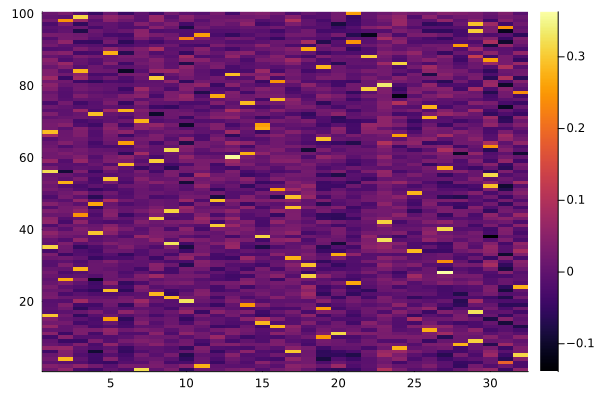

In [57]:
heatmap(qkvs[:,:,1])

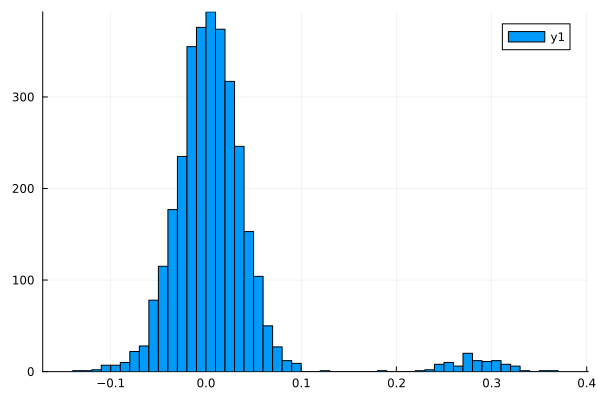

In [58]:
histogram(qkvs|>vec)

In [59]:
ps, st = Lux.setup(rng, sha)

((q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = (ff = (layer_1 = (weight = Float32[0.03707627 0.017316332 … 0.044608746 0.054087777; -0.08457034 0.03461641 … 0.055903554 0.0901459; … ; -0.053898368 0.06893188 … 0.015486689 0.012295164; 0.008499372 -0.037114874 … -0.015760778 0.003131628], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),),),), out_proj = (weight = Float32[0.046484627 0.036949813 … -0.078979455 -0.015783677; 0.04599454 0.009483468 … -0.04780482 0.07962409; … ; 0.07785712 -0.029458668 … 0.00051840633 -0.09471306; -0.043653153 -0.00017168609 … 0.0052362382 0.0050259233], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0,

In [60]:
y0 = sha(ddx, kvs, ps, st)

([0.34030264818053196 0.34099693944613296 … 0.34382511557615736 0.33963225430853217; 0.042551483339358105 0.03139788173424667 … 0.030423176997606757 -0.02562145770280264; … ; -0.0817906762027568 -0.10889717955709628 … -0.09034848121506894 -0.1265086508851078; 0.19416396219499674 0.2512644464231669 … 0.2222869922799263 0.2713626518731425;;;], NamedTuple())

In [61]:
size(ddx)

(512, 100, 1)

In [62]:
size(kvs)

(512, 32, 1)

In [63]:
y0[1] |> size

(512, 100, 1)

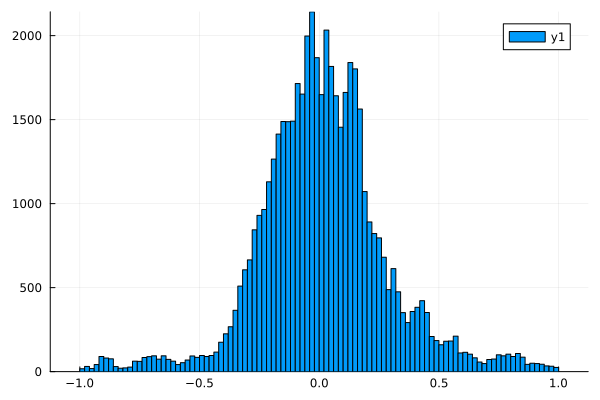

In [64]:
histogram(y0[1]|>vec)

## Define residual block

In [70]:
dims = (n_hd, Int(n_hd / 2), n_hd)

(512, 256, 512)

In [71]:
rb = ResidualBlock(dims)

ResidualBlock(
    ff = Chain(
        layer_1 = PhasorDense((512, 256)),  # 131_584 parameters
        layer_2 = PhasorDense((256, 512)),  # 132_096 parameters
    ),
)         # Total: 263_680 parameters,
          #        plus 0 states.

In [72]:
ps_rb, st_rb = Lux.setup(rng, rb)

((ff = (layer_1 = (weight = Float32[0.060782596 0.0083217155 … -0.09283957 0.01979631; -0.03231306 -0.047622334 … -0.032807246 -0.014534502; … ; -0.0055202097 0.005372463 … -0.008445408 -0.01558643; -0.07539891 0.062459167 … 0.0811941 0.0334536], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[0.025216693 0.031190928 … -0.07285559 -0.019652784; -0.05952038 0.045952473 … 0.082077384 -0.0020943529; … ; -0.048227135 0.03984171 … 0.06818277 0.020252464; -0.021200012 0.07551934 … 0.028250584 -0.06390136], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])),), (ff = (layer_

In [73]:
y1 = rb(y0[1], ps_rb, st_rb)

([0.25972113023408117 0.270575313063413 … 0.2908067794297575 0.2509247577398632; -0.04291204934320347 0.027367065278539382 … 0.012882110522018708 -0.03258851404865559; … ; -0.04461680523580325 -0.11519753932631838 … -0.11809972959226234 -0.11850100240069128; 0.24657141201038457 0.3028834043919937 … 0.16649262235801476 0.2870405422256792;;;], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [74]:
size(y1[1])

(512, 100, 1)

## Define single-head transformer block

In [75]:
struct SingleHeadCABlock <: LuxCore.AbstractLuxContainerLayer{(:attn, :q_norm, :kv_norm, :ff_norm, :ff)}
    attn::SingleHeadAttention
    q_norm
    kv_norm
    ff_norm
    ff
end

In [76]:
function SingleHeadCABlock(d_input::Int, d_model::Int, n_q::Int, n_kv::Int; dropout::Real=0.1, kwargs...)
    SingleHeadCABlock(
        SingleHeadAttention(d_input, d_model; kwargs...),
        LayerNorm((d_model, n_q)),
        LayerNorm((d_model, n_kv)),
        LayerNorm((d_model, n_q)),
        Chain(PhasorDense(d_input => d_model),
            Dropout(dropout),
            PhasorDense(d_model => d_input)),
    )
end

SingleHeadCABlock

In [131]:
tb = SingleHeadCABlock(n_hd, n_hd, size(ddx,2), size(kvs,2),
                            q_proj = identity_layer, 
                            k_proj = identity_layer,
                            v_proj = identity_layer)

SingleHeadCABlock(
    attn = SingleHeadAttention(
        q_proj = Chain(
            layer_1 = WrappedFunction(#41),
        ),
        k_proj = Chain(
            layer_1 = WrappedFunction(#41),
        ),
        v_proj = Chain(
            layer_1 = WrappedFunction(#41),
        ),
        out_proj = PhasorDense((512, 512)),  # 263_168 parameters
    ),
    q_norm = LayerNorm((512, 100), affine=true, dims=Colon()),  # 102_400 parameters
    kv_norm = LayerNorm((512, 32), affine=true, dims=Colon()),  # 32_768 parameters
    ff_norm = LayerNorm((512, 100), affine=true, dims=Colon()),  # 102_400 parameters
    ff = Chain(
        layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
        layer_2 = Dropout(0.1),
        layer_3 = PhasorDense((512, 512)),  # 263_168 parameters
    ),
)         # Total: 1_027_072 parameters,
          #        plus 2 states.

In [132]:
#TODO - add mask

In [133]:
function (tb::SingleHeadCABlock)(q, kv, mask, ps, st)
    # Attention path
    norm_q = tb.q_norm(q, ps.q_norm, st.q_norm)[1]
    norm_kv = tb.kv_norm(kv, ps.kv_norm, st.kv_norm)[1]
    attn_out, st_attn = tb.attn(q, kv, ps.attn, st.attn)
    x = v_bind(q, attn_out)
    
    # Feed-forward path
    norm_x = tb.ff_norm(x, ps.ff_norm, st.ff_norm)[1]
    ff_out, st_ff = tb.ff(x, ps.ff, st.ff)
    x = v_bind(x, ff_out)
    
    return x, merge(st_attn, st_ff)
end

In [134]:
ps_tb, st_tb = Lux.setup(rng, tb)

((attn = (q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = NamedTuple(),), out_proj = (weight = Float32[-0.03790143 -0.00013221147 … 0.018505719 0.011277364; 0.040811796 0.04101907 … 0.008052567 0.023975318; … ; 0.020890204 0.006828017 … -0.04971596 -0.047709666; 0.007953293 0.049838148 … -0.017309986 -0.00037905172], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), q_norm = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;]), kv_norm = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 …

In [135]:
ddyh, _ = tb(ddx, kvs, missing, ps_tb, st_tb)

([0.4645286535423099 -0.38129270144799987 … 0.11567776395373963 -0.22067368823872302; -0.6696010541432553 -0.4674016302802877 … -0.00398085670782411 0.8225567065553092; … ; 0.9892751535894075 -0.8902261564875281 … 0.9470733696831524 0.13559760937176701; -0.7458675699847271 0.3102630121267156 … 0.9210543205761723 -0.2035125811182148;;;], (layer_1 = NamedTuple(), layer_2 = (rng = Xoshiro(0x13e25085303e5a8a, 0x2b93531add3e69fd, 0x6e4605a3451cbdf9, 0xbaf339a7f14ec8c2, 0xc90c4a0730db3f7e), training = Val{true}()), layer_3 = NamedTuple()))

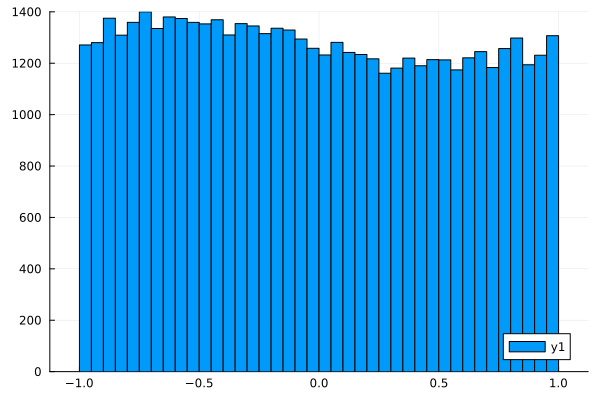

In [136]:
histogram(vec(ddyh))

In [137]:
similarity_loss(ddyh, ddy)

100×1 Matrix{Float64}:
 1.003933830772665
 0.9914106850388249
 1.0167489487431105
 0.9684587751135789
 0.9923878395829534
 0.9832934374980001
 1.0207413279848876
 0.963079541769647
 1.0509358063210021
 1.0074228070680233
 0.9849250422080758
 1.0557788574639464
 0.9918503564906236
 ⋮
 1.0411146090876953
 1.01148876940058
 0.9560965662974978
 0.9993271616069562
 1.0070218016716355
 0.9593840611607684
 1.0389666399695028
 1.0101258814361391
 1.009001450362444
 1.0561997392942533
 1.0324150477962508
 0.9712543924710519

# Training Test

In [138]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = n_batch    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [139]:
args = Args()

Args(0.0003, 128, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

## Create the dataset

In [140]:
"""
Generate a single batch of query/key/value data for training
"""
function generate_single(args, n_keys::Int=64, n_queries::Int=32, n_hd=512, generator::Function=direct_dataset)
    rng = args.rng
    n_batch = args.batchsize

    queries = zeros(Float32, (n_hd, n_queries, n_batch))
    keys = zeros(Float32, (n_hd, n_keys, n_batch))
    values = zeros(Float32, (n_hd, n_queries, n_batch))

    for i in 1:n_batch
        kv = KeyValueData(n_keys, rng=rng)
        keys[:,:,i] = kv.symbols

        x, y = generator(n_queries, kv, args.rng)
        queries[:,:,i] = x
        values[:,:,i] = y
    end

    return queries, keys, values
end

generate_single

In [141]:
data = generate_single(args, 64, 32, n_hd)

(Float32[-0.5998617 0.9294005 … 0.40823162 -0.7595898; -0.19436753 -0.43530804 … -0.989759 -0.46591073; … ; -0.59577364 -0.7752458 … -0.50756335 0.67780036; -0.5940303 -0.3931235 … 0.86004645 -0.90167075;;; -0.0063425303 -0.8700677 … -0.4958347 -0.015144527; -0.66509753 0.9672054 … 0.7539746 -0.9700619; … ; -0.29683214 0.861776 … -0.044232905 0.35945272; -0.68267125 0.5033103 … -0.020394266 0.323368;;; -0.37044168 0.20970678 … 0.055761218 -0.086841464; -0.4576785 -0.975174 … 0.96841097 -0.01574707; … ; -0.095134914 -0.734629 … -0.46911013 0.6865506; 0.31745052 0.4920721 … -0.077233315 -0.97503364;;; … ;;; -0.1878519 -0.58149 … -0.76312304 -0.8862688; 0.6527932 0.08364612 … 0.46514773 -0.112300396; … ; -0.3493209 -0.015796244 … 0.040506005 -0.40034097; 0.33259463 -0.7324557 … -0.21136832 -0.8123142;;; -0.13058478 0.51161313 … -0.9556822 -0.7534316; -0.5658846 0.47842157 … -0.3589818 0.08574444; … ; -0.15337712 -0.45815086 … 0.9402418 -0.34717733; 0.8312197 -0.012736738 … 0.11699331 0.15

In [142]:
length(data)

3

In [143]:
x, y, z = data

(Float32[-0.5998617 0.9294005 … 0.40823162 -0.7595898; -0.19436753 -0.43530804 … -0.989759 -0.46591073; … ; -0.59577364 -0.7752458 … -0.50756335 0.67780036; -0.5940303 -0.3931235 … 0.86004645 -0.90167075;;; -0.0063425303 -0.8700677 … -0.4958347 -0.015144527; -0.66509753 0.9672054 … 0.7539746 -0.9700619; … ; -0.29683214 0.861776 … -0.044232905 0.35945272; -0.68267125 0.5033103 … -0.020394266 0.323368;;; -0.37044168 0.20970678 … 0.055761218 -0.086841464; -0.4576785 -0.975174 … 0.96841097 -0.01574707; … ; -0.095134914 -0.734629 … -0.46911013 0.6865506; 0.31745052 0.4920721 … -0.077233315 -0.97503364;;; … ;;; -0.1878519 -0.58149 … -0.76312304 -0.8862688; 0.6527932 0.08364612 … 0.46514773 -0.112300396; … ; -0.3493209 -0.015796244 … 0.040506005 -0.40034097; 0.33259463 -0.7324557 … -0.21136832 -0.8123142;;; -0.13058478 0.51161313 … -0.9556822 -0.7534316; -0.5658846 0.47842157 … -0.3589818 0.08574444; … ; -0.15337712 -0.45815086 … 0.9402418 -0.34717733; 0.8312197 -0.012736738 … 0.11699331 0.15

In [144]:
blk = SingleHeadCABlock(n_hd, n_hd, 32, 64,
                            q_proj = identity_layer, 
                            k_proj = identity_layer,)

SingleHeadCABlock(
    attn = SingleHeadAttention(
        q_proj = Chain(
            layer_1 = WrappedFunction(#41),
        ),
        k_proj = Chain(
            layer_1 = WrappedFunction(#41),
        ),
        v_proj = Chain(
            layer_1 = ResidualBlock(
                ff = Chain(
                    layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
                ),
            ),
        ),
        out_proj = PhasorDense((512, 512)),  # 263_168 parameters
    ),
    q_norm = LayerNorm((512, 32), affine=true, dims=Colon()),  # 32_768 parameters
    kv_norm = LayerNorm((512, 64), affine=true, dims=Colon()),  # 65_536 parameters
    ff_norm = LayerNorm((512, 32), affine=true, dims=Colon()),  # 32_768 parameters
    ff = Chain(
        layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
        layer_2 = Dropout(0.1),
        layer_3 = PhasorDense((512, 512)),  # 263_168 parameters
    ),
)         # Total: 1_183_744 parameters,
          #        plus 2 stat

In [145]:
ps, st = Lux.setup(args.rng, blk)

((attn = (q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = (ff = (layer_1 = (weight = Float32[-0.070411295 -0.024948636 … -0.028599845 0.009753855; 0.0030030548 0.006534984 … 0.07829574 -0.007996966; … ; -0.011746989 -0.064607464 … 0.021445032 -0.057507876; -0.03420263 0.045939058 … 0.0578303 -0.08906746], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),),),), out_proj = (weight = Float32[0.0146332765 0.01285405 … 0.017667405 -0.0499156; -0.004192376 0.055514775 … -0.02502084 -0.015619112; … ; 0.014751042 0.04540592 … 0.07934168 0.042872958; -0.027942762 0.078839794 … -0.02776268 0.038842224], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.

In [147]:
blk_call(x,y,p) = tb(x, y, missing, p, st)

blk_call (generic function with 1 method)

In [148]:
zh2 = blk_call(x, y, ps);

In [149]:
x = x |> gdev
y = y |> gdev
z = z |> gdev;

In [150]:
ps = ps |> gdev

(attn = (q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = (ff = (layer_1 = (weight = Float32[-0.070411295 -0.024948636 … -0.028599845 0.009753855; 0.0030030548 0.006534984 … 0.07829574 -0.007996966; … ; -0.011746989 -0.064607464 … 0.021445032 -0.057507876; -0.03420263 0.045939058 … 0.0578303 -0.08906746], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),),),), out_proj = (weight = Float32[0.0146332765 0.01285405 … 0.017667405 -0.0499156; -0.004192376 0.055514775 … -0.02502084 -0.015619112; … ; 0.014751042 0.04540592 … 0.07934168 0.042872958; -0.027942762 0.078839794 … -0.02776268 0.038842224], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0

In [151]:
yo = blk_call(x, y, ps)

([-0.5100409615939026 -0.744981828597665 … 0.7965267351379195 -0.4022772651214097; -0.3106854420926065 -0.30975580501077493 … -0.9647287748929292 -0.25083361021180806; … ; -0.5725165604493749 0.978857013950301 … -0.42600302181535477 0.40374897994207504; -0.822854090897612 -0.8856414358458249 … 0.5253938140524017 0.7936605800565708;;; -0.3108413431090009 -0.7309264757275069 … -0.5332993675990592 0.06692770570244799; -0.11698567184660247 -0.7987018650160804 … -0.9204497816630223 -0.6229353732774303; … ; -0.1350870087958831 -0.4843347020999157 … 0.09752743571879252 0.5443904735241101; -0.32892240523552263 0.7088689580640768 … 0.49361646493078615 0.7445008335743153;;; 0.08438328338254397 0.395724121776023 … 0.24631237610424095 -0.10261267872730273; -0.7731888542154535 0.662930781768948 … -0.8258341453478693 -0.4561983645859493; … ; 0.12698647314060407 -0.737548190505862 … -0.3719488579559189 0.14105724606140058; 0.4860164406414398 0.9446866519159669 … 0.2148634528854092 -0.7986252296706186

In [153]:
v, gs = withgradient(p -> mean(similarity_loss(blk_call(x, y, p)[1], z)), ps)

(val = 1.0007314562387846, grad = ((attn = (q_proj = nothing, k_proj = nothing, v_proj = nothing, out_proj = (weight = Float32[-0.00016084478 -5.714653f-6 … 0.00010093267 6.085331f-6; 2.1443862f-5 -0.0002512431 … 5.2018546f-5 9.039902f-5; … ; -0.00016354985 0.00012897847 … 6.485525f-5 -1.9167956f-5; 4.2119194f-5 8.809711f-6 … -4.2526844f-5 -9.633765f-5], bias_real = Float32[-6.484505f-5, 0.00014975527, 1.1063527f-5, -3.5997316f-5, 2.2281176f-5, 2.4967647f-5, 5.764503f-5, 1.3685057f-5, 6.403423f-5, -0.00017915653  …  2.6030448f-6, -5.805705f-6, -0.0001047985, 3.8815157f-5, -4.8291105f-5, -7.7649325f-5, -0.00011044087, 0.0001475407, 4.785844f-5, -2.028799f-5], bias_imag = Float32[1.5553102f-5, 0.00025825083, -2.2721251f-6, 0.00011280871, 6.967583f-5, 1.9665802f-5, -6.791508f-5, 6.370041f-5, -0.00021565477, 0.00010895553  …  -3.1393898f-5, 2.7978564f-5, 3.7439735f-5, 1.3986788f-5, 5.376563f-5, 0.0001703873, 4.3284777f-5, 2.2041006f-5, -6.9260816f-5, -5.08832f-5])), q_norm = nothing, kv_no

In [154]:
function find_nan_fields(data::Tuple)
    nan_paths = Set{String}()
    
    for nt in data
        _check_nested(nt, "", nan_paths)
    end
    
    return sort(collect(nan_paths))
end

function _check_nested(obj::NamedTuple, parent_path::String, results::Set{String})
    for (name, value) in pairs(obj)
        current_path = isempty(parent_path) ? "$name" : "$parent_path.$name"
        
        if typeof(value) <: AbstractArray
            isnan(reduce(*, value)) && push!(results, current_path)
        elseif value isa NamedTuple
            _check_nested(value, current_path, results)
        end
    end
end


_check_nested (generic function with 1 method)

In [156]:
find_nan_fields(gs)

String[]

In [160]:
function train(model, ps, train_loader, args; verbose::Bool = false)
    if CUDA.functional() && args.use_cuda
       @info "Training on CUDA GPU"
       CUDA.allowscalar(false)
       device = gpu_device()
   else
       @info "Training on CPU"
       device = cpu_device()
   end

   ## Optimizer
   opt_state = Optimisers.setup(Adam(args.η), ps)
   losses = []
   grads = []

   ## Training
   for epoch in 1:args.epochs
       for batch in train_loader
            (x, y, z) = batch .|> device
            
            lf = p -> mean(similarity_loss(model(x, y, p)[1], z))
            lossval, gs = withgradient(lf, ps)
            if verbose
                println(reduce(*, ["Epoch ", string(epoch), " loss: ", string(lossval)]))
            end
            append!(losses, lossval)
            append!(grads, gs |> cdev)
            print(find_nan_fields(gs))
            
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
       end
   end

   return losses, ps
end

train (generic function with 1 method)

In [161]:
args.epochs = 1
args.use_cuda = true

true

In [162]:
losses, ps_t = train(blk_call, ps, training_set, args, verbose=true)

[ Info: Training on CUDA GPU


Epoch 1 loss: 1.000276959893385
String[]Epoch 1 loss: 0.9995961461107878
String[]Epoch 1 loss: 1.000050329648798
String[]Epoch 1 loss: 0.9993236355254895
String[]Epoch 1 loss: 0.998953512560724
["attn.out_proj.bias_imag", "attn.out_proj.bias_real", "attn.out_proj.weight"]Epoch 1 loss: NaN
["attn.out_proj.bias_imag", "attn.out_proj.bias_real", "attn.out_proj.weight", "ff.layer_1.bias_imag", "ff.layer_1.bias_real", "ff.layer_1.weight", "ff.layer_3.bias_imag", "ff.layer_3.bias_real", "ff.layer_3.weight"]Epoch 1 loss: NaN
["attn.out_proj.bias_imag", "attn.out_proj.bias_real", "attn.out_proj.weight", "ff.layer_1.bias_imag", "ff.layer_1.bias_real", "ff.layer_1.weight", "ff.layer_3.bias_imag", "ff.layer_3.bias_real", "ff.layer_3.weight"]Epoch 1 loss: NaN
["attn.out_proj.bias_imag", "attn.out_proj.bias_real", "attn.out_proj.weight", "ff.layer_1.bias_imag", "ff.layer_1.bias_real", "ff.layer_1.weight", "ff.layer_3.bias_imag", "ff.layer_3.bias_real", "ff.layer_3.weight"]Epoch 1 loss: NaN
["attn.o

LoadError: InterruptException:

In [ ]:
function train_attn(model_call, ps, train_loader, args)
    opt_state = Optimisers.setup(Adam(args.η), ps)
    params = ps
    losses = []

    for i in 1:args.epochs
        for batch in train_loader
            (x, y, z) = batch .|> gdev
            
            lf = p -> mean(similarity_loss(model_call(x, y, p)[1], z))
            val, grads = withgradient(lf, params)
            return val, grads
            println(val)
            println(grads)
            opt_state, params = Optimisers.update(opt_state, params, grads[1])
            println(params)

            append!(losses, val)
        end
    end

    return losses, params
end    
    

train_attn (generic function with 1 method)

In [ ]:
function eval_batch(i::Int)
    (x, y, z) = training_set[i] .|> gdev
    lf = p -> mean(similarity_loss(blk_call(x, y, p)[1], z))
    v, gs = withgradient(lf, ps)
    return v, gs
end

eval_batch (generic function with 1 method)

In [ ]:
ca, cb, cc = training_set[1] .|> gdev;

In [ ]:
size(x), size(ca)

((512, 32, 128), (512, 32, 128))

In [ ]:
size(y), size(cb)

((512, 64, 128), (512, 64, 128))

In [ ]:
size(z), size(cc)

((512, 32, 128), (512, 32, 128))